[1.0, 0.25]


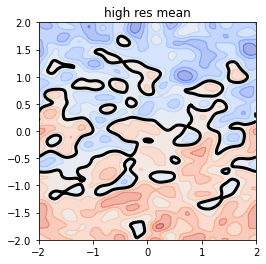

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import imageio
import utils

xrange = (-2, 2)
yrange = (-2, 2)
interp_method = "nearest"

f = "2d-reals/se/aniso=[1.0000,2.0000,1.0000]-s=1.000-l=0.250/sample-2048-0.bin"

p_start_index = f.find("s=")
p_end_index = f.find("/", p_start_index)
params = f[p_start_index:p_end_index]

params = params.split("-")
gt_kparams = [float(ps.split("=")[-1]) for ps in params]

print(gt_kparams)

nps = int(f.split("-")[-2])
real = np.reshape(np.fromfile(f, dtype=np.cdouble), (nps,nps))
real = np.real(real)

xs = np.linspace(*xrange, real.shape[0])
ys = np.linspace(*yrange, real.shape[1])
xx, yy = np.meshgrid(xs, ys)

real_interp = interp.RegularGridInterpolator((xs, ys), real, "linear") 

def mean(x,y):
    x = np.clip(x, *xrange)
    y = np.clip(y, *yrange)
    return real_interp((x,y)) + y
    #return np.sin(x*np.pi*8) * 0.4 + y

fig, axs = plt.subplots(1,1, figsize=(8,4))
axs = np.atleast_1d(axs)
axs[0].set_title("high res mean")
utils.plot_realization(mean(xx,yy), axs[0], xx, yy)


In [91]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib import cm

%matplotlib inline
%load_ext autoreload
%autoreload 2

xv, yv = torch.meshgrid(torch.linspace(*xrange, 50), torch.linspace(*yrange, 50), indexing="ij")

train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.from_numpy(mean(train_x[:, 0].numpy(), train_x[:, 1].numpy())).to(dtype=torch.float32)

print(train_x.dtype, train_y.dtype)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size=2)
        self.covar_module = gpytorch.kernels.RBFKernel(ard_num_dims=2) #gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

training_iter = 1000
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)  # Includes GaussianLikelihood parameters
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.prior_mode():
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()

        # print('Iter %d/%d - Loss: %.3f  Variance: %.3f lengthscale: %.3f,%.3f  noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.outputscale.item(),
        #     model.covar_module.base_kernel.lengthscale[0,0].item(),
        #     model.covar_module.base_kernel.lengthscale[0,1].item(),
        #     model.likelihood.noise.item()
        # ))
        print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item()} lengthscale: {model.covar_module.lengthscale.detach().numpy()}  noise: {model.likelihood.noise.item()}')
        optimizer.step()
        scheduler.step()

ls = model.covar_module.lengthscale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.float32 torch.float32
Iter 1/1000 - Loss: 0.8736009001731873 lengthscale: [[0.6931472 0.6931472]]  noise: 0.6932471990585327
Iter 2/1000 - Loss: 0.792741596698761 lengthscale: [[0.59813887 0.7981388 ]]  noise: 0.5982388854026794
Iter 3/1000 - Loss: 0.7112053632736206 lengthscale: [[0.51428175 0.9078778 ]]  noise: 0.513839602470398
Iter 4/1000 - Loss: 0.627526044845581 lengthscale: [[0.44026452 1.0108609 ]]  noise: 0.4394600987434387
Iter 5/1000 - Loss: 0.5395755171775818 lengthscale: [[0.375691 1.070623]]  noise: 0.3743893802165985
Iter 6/1000 - Loss: 0.45248842239379883 lengthscale: [[0.3192729 1.088054 ]]  noise: 0.31785255670547485
Iter 7/1000 - Loss: 0.3673979938030243 lengthscale: [[0.27149844 1.062901  ]]  noise: 0.2690468728542328
Iter 8/1000 - Loss: 0.2829970717430115 lengthscale: [[0.23191752 1.0152626 ]]  noise: 0.2271583378314972
Iter 9/1000 - Loss: 0.1975380927324295 lengthscale: [

Parameter name: likelihood.noise_covar.raw_noise           value = [-11.026175]
Parameter name: mean_module.weights                        value = [[-0.88660955]
 [ 0.7169942 ]]
Parameter name: mean_module.bias                           value = [2.1701226]
Parameter name: covar_module.raw_lengthscale               value = [[-1.0112128  0.7091874]]


c:\Users\dario\.conda\envs\research\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\dario\.conda\envs\research\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\dario\.conda\envs\research\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Text(0.5, 1.0, 'Sample')

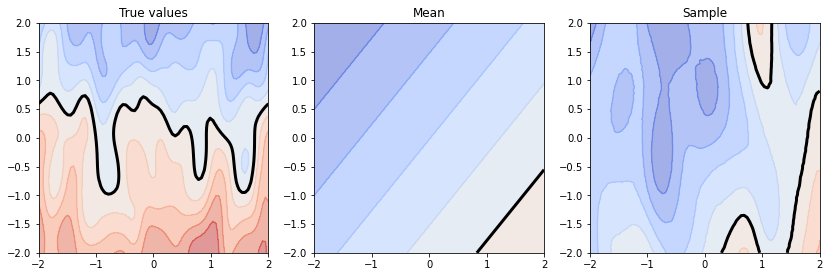

In [92]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.detach().numpy()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(1, 3, figsize=(14, 10))

# Test points
n1, n2 = 80, 80
xv, yv = torch.meshgrid(torch.linspace(*xrange, n1), torch.linspace(*yrange, n2), indexing="ij")
xv, yv = torch.meshgrid(torch.linspace(-2,2, n1), torch.linspace(-2,2, n2), indexing="ij")
f = mean(xv.numpy(), yv.numpy())

#model.covar_module.lengthscale = ls * 0.5
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.prior_mode(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False, solves=False):
#with torch.no_grad(), gpytorch.settings.prior_mode():
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = likelihood(model(test_x))
    pred_mean = predictions.mean
    sample=predictions.sample()

extent = (xv.min(), xv.max(), yv.max(), yv.min())
utils.plot_realization(f, ax[0], xv, yv)
ax[0].set_title('True values')

utils.plot_realization(pred_mean.detach().numpy().reshape(n1, n2), ax[1], xv, yv)
ax[1].set_title('Mean')

utils.plot_realization(sample.detach().numpy().reshape(n1, n2), ax[2], xv, yv)
ax[2].set_title('Sample')

2.0 2.0
0.07108182906925233


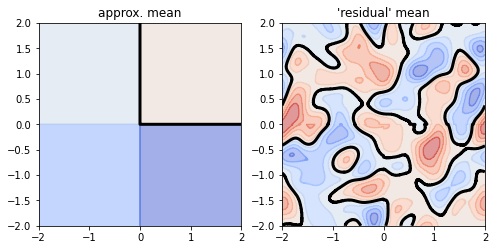

In [97]:

disc_res = 2
disc_samples = 5000
filter_width_x = (xrange[1] - xrange[0])/disc_res
filter_width_y = (yrange[1] - yrange[0])/disc_res

print(filter_width_x, filter_width_y)

disc_x = np.linspace(*xrange, disc_res, False) + filter_width_x*0.5
disc_y = np.linspace(*yrange, disc_res, False) + filter_width_x*0.5
disc_mean = np.zeros((disc_res,disc_res))

for i, x in enumerate(disc_x):
    for j, y in enumerate(disc_y):
        disc_mean[i,j] = 0
        for s in range(disc_samples):
            px = x + np.random.normal(-0.5, 0.5) * filter_width_x
            py = y + np.random.normal(-0.5, 0.5) * filter_width_y
            disc_mean[i,j] += mean(px,py)
        disc_mean[i,j] /= disc_samples

if disc_res > 1:
    grid_interp = interp.RegularGridInterpolator((disc_x, disc_y), disc_mean, interp_method, False, None) 
    def approx_mean(x,y):
        x = np.clip(x, *xrange)
        y = np.clip(y, *yrange)
        return grid_interp((x,y))
else:
    def approx_mean(x,y):
        return x*0 + y*0 + disc_mean[0,0]
    
def residual(x,y):
    return mean(x,y) - approx_mean(x,y) 

print(disc_mean.mean())

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs = np.atleast_1d(axs)
axs[0].set_title("approx. mean")
utils.plot_realization(approx_mean(xx,yy), axs[0], xx, yy)

axs[1].set_title("'residual' mean")
utils.plot_realization(residual(xx,yy), axs[1], xx, yy)

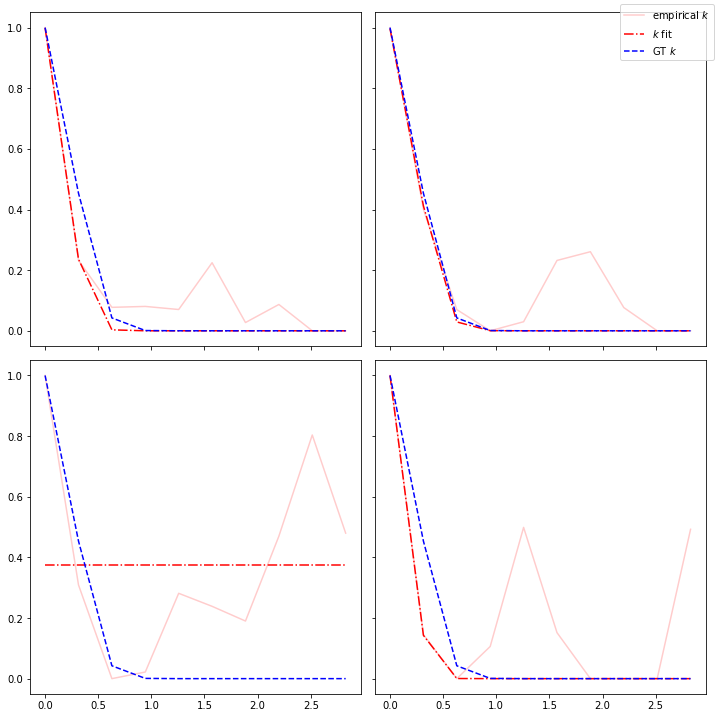

In [100]:
def kernel_fit(l, sigma, ls):
    return sigma**2 * np.exp(-(l**2)/(2*ls**2))

kernel_params_x = np.zeros((disc_res,disc_res,2))

tpc_size = 10
tpc_fig, tpc_axs = plt.subplots(disc_res,disc_res, figsize=(10,10), sharex=True, sharey=True)
tpc_axs = np.atleast_2d(tpc_axs)

max_cov_dist_x = np.sqrt(filter_width_x**2 + filter_width_y**2)
xs_hist = np.linspace(0, max_cov_dist_x, tpc_size)

for i, x in enumerate(disc_x):
    for j, y in enumerate(disc_y):
        k_x = np.zeros(tpc_size)
        k_x_sc = np.zeros(tpc_size)

        variance = 0

        for s in range(disc_samples*10):
            p1x = x + np.random.uniform(-0.5, 0.5) * filter_width_x
            p1y = y + np.random.uniform(-0.5, 0.5) * filter_width_y

            p2x = x + np.random.uniform(-0.5, 0.5) * filter_width_x
            p2y = y + np.random.uniform(-0.5, 0.5) * filter_width_y

            pdx = p2x - p1x
            pdy = p2y - p1y
            ld = np.sqrt(pdx*pdx + pdy*pdy)

            idx_x = int(np.clip(tpc_size*ld / (max_cov_dist_x), 0, tpc_size-1))

            cov_ld = residual(p1x,p1y) * residual(p2x,p2y)

            variance += residual(p1x,p1y)**2

            k_x[idx_x] += cov_ld
            k_x_sc[idx_x] += 1

        
        variance /= disc_samples*10 - 1
        k_x /= np.maximum(k_x_sc, 1)
        k_x /= k_x[0]
        #k_x *= variance

        tpc_axs[i,j].plot(xs_hist, np.clip(k_x, 0, 10), label="empirical $k$", color="red", alpha=0.2)

        k_x_params, _ = opt.curve_fit(kernel_fit, xs_hist, k_x, bounds=([0,0],[np.inf, np.inf]))

        tpc_axs[i,j].plot(xs_hist, kernel_fit(xs_hist, *k_x_params), label="$k$ fit", color="red", linestyle="-.")
        tpc_axs[i,j].plot(xs_hist, kernel_fit(xs_hist, *gt_kparams), label="GT $k$", color="BLUE", linestyle="--")

        kernel_params_x[i,j] = k_x_params


handles, labels = tpc_axs[0,0].get_legend_handles_labels()
tpc_fig.legend(handles, labels, loc='upper right')
tpc_fig.tight_layout()

[[[9.99651781e-01 1.85019719e-01]
  [9.98285223e-01 2.36506600e-01]]

 [[6.11917619e-01 7.23948715e+03]
  [1.00012408e+00 1.59314366e-01]]]


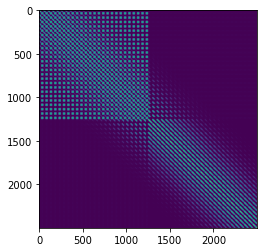

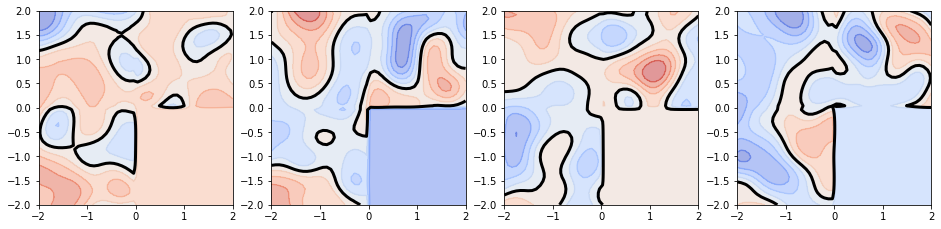

In [101]:

kernel_params_x_interp = interp.RegularGridInterpolator((disc_x, disc_y), kernel_params_x, "nearest", False, None)
print(kernel_params_x)
def k(x0,y0,x1,y1):
    p0x = np.moveaxis(kernel_params_x_interp((x0,y0)), -1, 0)
    p1x = np.moveaxis(kernel_params_x_interp((x1,y1)), -1, 0)

    p0x = np.maximum(p0x, 0.00001)
    p1x = np.maximum(p1x, 0.00001)

    dx = x0-x1
    dy = y0-y1

    detAnisoA = p0x[1]**2
    detAnisoB = p1x[1]**2

    anisoABavg = 0.5 * (p0x[1] + p1x[1])
    detAnisoABavg = anisoABavg**2
    ansioFac = (detAnisoA**0.25 * detAnisoB**0.25) / np.sqrt(detAnisoABavg)

    anisoABavgInv = (1/anisoABavg)
    ln = np.sqrt(dx*anisoABavgInv*dx + dy*anisoABavgInv*dy)

    return np.sqrt(p0x[0]) * np.sqrt(p1x[0]) * ansioFac * kernel_fit(ln, 1, 1)
                
    #return 0.5*(kernel_fit(dx, *p0x) * kernel_fit(dy, *p0y) + 
    #            kernel_fit(dx, *p1x) * kernel_fit(dy, *p1y))


def mean_and_cov(xs,ys):
    M = approx_mean(xs, ys)
    x0s, x1s = np.meshgrid(xs, xs)
    y0s, y1s = np.meshgrid(ys, ys)
    K = k(x0s, y0s, x1s, y1s)
    return M, K


real_res = 50
real_x = np.linspace(*xrange, real_res)
real_y = np.linspace(*yrange, real_res)
real_xx, real_yy = np.meshgrid(real_x, real_y)

M, K = mean_and_cov(real_xx.ravel(), real_yy.ravel())

Kimg = K.reshape(real_res*real_res, real_res*real_res)
plt.show()
plt.imshow(Kimg)
plt.show()

dist = stats.multivariate_normal(M, K, allow_singular=True)
samples = dist.rvs(4)

fig, axs = plt.subplots(1, samples.shape[0], figsize=(samples.shape[0]*4, 4))
for i in range(samples.shape[0]):
    utils.plot_realization(samples[i].reshape(real_res, real_res), axs[i], real_xx, real_yy)


In [ ]:

fig_occ, axs_occ = plt.subplots(1,4, figsize=(16,4))
axs_occ[0].set_title("downsampled mean (linear interp)")
utils.plot_realization(approx_mean(xx,yy), axs_occ[0], xx, yy)
axs_occ[0].grid(True, "major", "both")
axs_occ[0].set_xticks(disc_x)
axs_occ[0].set_yticks(disc_y)

axs_occ[1].set_title("occupancy based on downsampled mean")
utils.plot_realization( -((interp_mean < 0) - 0.5), axs_occ[1], xx, yy)
axs_occ[1].grid(True, "major", "both")
axs_occ[1].set_xticks(disc_x)
axs_occ[1].set_yticks(disc_y)

axs_occ[2].set_title("downsampled occupancy (linear interp)")
utils.plot_realization(grid_occ_interp((xx,yy)), axs_occ[2], xx, yy)
axs_occ[2].grid(True, "major", "both")
axs_occ[2].set_xticks(disc_x)
axs_occ[2].set_yticks(disc_y)
var = k(real_xx.ravel(), real_yy.ravel(), real_xx.ravel(), real_yy.ravel())
ptwise_occupancy = stats.norm.cdf(np.zeros_like(M), loc=M, scale=var*100+0.0001) - 0.5
axs_occ[3].set_title("Pointwise GP Occupancy")
utils.plot_realization(-ptwise_occupancy.reshape(real_res, real_res), axs_occ[3], real_xx, real_yy)
fig_occ.tight_layout()